# Import package

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# plt.style.use('fivethirtyeight')
sns.set(style = 'whitegrid',context = 'notebook')

# generate classification report using predictions for categorical model
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score, roc_curve, roc_auc_score
from sklearn import (metrics,  linear_model, preprocessing)
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, KFold, learning_curve, StratifiedKFold


# Import data

In [2]:
df = pd.read_csv("diabetes.csv")
df.shape

(768, 9)

In [3]:
original_df = df.copy()

In [4]:
df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)

In [5]:
df.shape

(768, 9)

# Replace missing values and EDA

In [6]:
def median_target(var):   
    temp = df[df[var].notnull()]
    temp = temp[[var, 'Outcome']].groupby(['Outcome'])[[var]].median().reset_index()
    return temp

### Insulin

In [7]:
median_target('Insulin')

,Outcome,Insulin
0,0,102.5
1,1,169.5


In [8]:
df.loc[(df['Outcome'] == 0 ) & (df['Insulin'].isnull()), 'Insulin'] = median_target('Insulin').iloc[0,1]
df.loc[(df['Outcome'] == 1 ) & (df['Insulin'].isnull()), 'Insulin'] = median_target('Insulin').iloc[1,1]

### Glucose

In [9]:
median_target('Glucose')

,Outcome,Glucose
0,0,107.0
1,1,140.0


In [10]:
df.loc[(df['Outcome'] == 0 ) & (df['Glucose'].isnull()), 'Glucose'] = median_target('Glucose').iloc[0,1]
df.loc[(df['Outcome'] == 1 ) & (df['Glucose'].isnull()), 'Glucose'] = median_target('Glucose').iloc[1,1]

### SkinThickness

In [11]:
median_target('SkinThickness')

,Outcome,SkinThickness
0,0,27.0
1,1,32.0


In [12]:
df.loc[(df['Outcome'] == 0 ) & (df['SkinThickness'].isnull()), 'SkinThickness'] = median_target('SkinThickness').iloc[0,1]
df.loc[(df['Outcome'] == 1 ) & (df['SkinThickness'].isnull()), 'SkinThickness'] = median_target('SkinThickness').iloc[1,1]

### BloodPressure 

In [13]:
median_target('BloodPressure')

,Outcome,BloodPressure
0,0,70.0
1,1,74.5


In [14]:
df.loc[(df['Outcome'] == 0 ) & (df['BloodPressure'].isnull()), 'BloodPressure'] = median_target('BloodPressure').iloc[0,1]
df.loc[(df['Outcome'] == 1 ) & (df['BloodPressure'].isnull()), 'BloodPressure'] = median_target('BloodPressure').iloc[1,1]

### BMI

In [15]:
median_target('BMI')

,Outcome,BMI
0,0,30.1
1,1,34.3


In [16]:
df.loc[(df['Outcome'] == 0 ) & (df['BMI'].isnull()), 'BMI'] = median_target('BMI').iloc[0,1]
df.loc[(df['Outcome'] == 1 ) & (df['BMI'].isnull()), 'BMI'] = median_target('BMI').iloc[1,1]

In [17]:
countvar=df.count()
meanvar=np.round(df.mean(),1)
minvar=df.min()
maxvar=df.max()
stdvar=np.round(df.std(),1)
# merge above Series' objects into a data frame, so that it is easy to check and operate
statistics=pd.concat([meanvar, minvar, maxvar, stdvar, countvar], axis=1)  
# remove the index of the data frame
des_stat_df=pd.DataFrame(statistics).reset_index()
# return the name list of the data frame
orname=list(des_stat_df.columns.values)
# rename the data frame
des_stat_df.rename(columns={orname[0]: 'variable', orname[1]: 'mean', 
                   orname[2]: 'min', orname[3]: 'max',
                   orname[4]: 'std',orname[5]: 'non_missing'},                  
                   inplace = True)
# get the total row number and append the column
des_stat_df['totcount']=df['Outcome'].count()
#calculate missing percentage
des_stat_df['miss_per']=np.round(100*(des_stat_df['totcount']-des_stat_df['non_missing'])/des_stat_df['totcount'],1)
des_stat_df

,variable,mean,min,max,std,non_missing,totcount,miss_per
0,Pregnancies,3.8,0.000,17.00,3.4,768,768,0.0
1,Glucose,121.7,44.000,199.00,30.5,768,768,0.0
2,BloodPressure,72.4,24.000,122.00,12.1,768,768,0.0
3,SkinThickness,29.1,7.000,99.00,8.9,768,768,0.0
4,Insulin,141.8,14.000,846.00,89.1,768,768,0.0
5,BMI,32.4,18.200,67.10,6.9,768,768,0.0
6,DiabetesPedigreeFunction,0.5,0.078,2.42,0.3,768,768,0.0
7,Age,33.2,21.000,81.00,11.8,768,768,0.0
8,Outcome,0.3,0.000,1.00,0.5,768,768,0.0


## Numerical variables

#### Create a sub-dataframe to store all numeric variables

In [18]:
# Create a sub-dataframe to store all numeric variables in the whole data frame
datatypes= ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numdf = df.drop(['Outcome'],axis=1).select_dtypes(include=datatypes)
target = df.Outcome

numpredictor = numdf.columns
print(numpredictor)
numdf.head()

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object')


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148.0,72.0,35.0,169.5,33.6,0.627,50
1,1,85.0,66.0,29.0,102.5,26.6,0.351,31
2,8,183.0,64.0,32.0,169.5,23.3,0.672,32
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33


#### Scaling dataset

In [19]:
from sklearn.preprocessing import StandardScaler
numdf_norm = pd.DataFrame(StandardScaler().fit_transform(numdf))
numdf_norm.columns = numdf.columns
numdf_norm.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.639947,0.864625,-0.032180,0.665181,0.311604,0.169483,0.468492,1.425995
1,-0.844885,-1.204727,-0.528124,-0.010112,-0.440843,-0.848549,-0.365061,-0.190672
2,1.233880,2.014265,-0.693438,0.327535,0.311604,-1.328478,0.604397,-0.105584
3,-0.844885,-1.073339,-0.528124,-0.685405,-0.536303,-0.630399,-0.920763,-1.041549
4,-1.141852,0.503310,-2.677212,0.665181,0.294758,1.551096,5.484909,-0.020496


In [20]:
numdf_norm.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,7.680000e+02,7.680000e+02,7.680000e+02,7.680000e+02,7.680000e+02,7.680000e+02,7.680000e+02,7.680000e+02
mean,2.544261e-17,1.604619e-16,-3.685926e-16,-3.928426e-17,-8.601337e-18,1.054567e-16,2.398978e-16,1.857600e-16
std,1.000652e+00,1.000652e+00,1.000652e+00,1.000652e+00,1.000652e+00,1.000652e+00,1.000652e+00,1.000652e+00
min,-1.141852e+00,-2.551447e+00,-3.999727e+00,-2.486187e+00,-1.434747e+00,-2.070186e+00,-1.189553e+00,-1.041549e+00
25%,-8.448851e-01,-7.202356e-01,-6.934382e-01,-4.603073e-01,-4.408430e-01,-7.176590e-01,-6.889685e-01,-7.862862e-01
50%,-2.509521e-01,-1.536274e-01,-3.218035e-02,-1.226607e-01,-4.408430e-01,-5.593870e-02,-3.001282e-01,-3.608474e-01
75%,6.399473e-01,6.100618e-01,6.290775e-01,3.275348e-01,3.116039e-01,6.057816e-01,4.662269e-01,6.602056e-01
max,3.906578e+00,2.539814e+00,4.100681e+00,7.868309e+00,7.909072e+00,5.041489e+00,5.883565e+00,4.063716e+00


In [21]:
from sklearn.preprocessing import MinMaxScaler
numdf_norm = pd.DataFrame(MinMaxScaler().fit_transform(numdf))
numdf_norm.columns = numdf.columns
numdf_norm.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.352941,0.670968,0.489796,0.304348,0.186899,0.314928,0.234415,0.483333
1,0.058824,0.264516,0.428571,0.239130,0.106370,0.171779,0.116567,0.166667
2,0.470588,0.896774,0.408163,0.271739,0.186899,0.104294,0.253629,0.183333
3,0.058824,0.290323,0.428571,0.173913,0.096154,0.202454,0.038002,0.000000
4,0.000000,0.600000,0.163265,0.304348,0.185096,0.509202,0.943638,0.200000


In [22]:
numdf_norm.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,0.226180,0.501142,0.493769,0.240107,0.153550,0.291097,0.168179,0.204015
std,0.198210,0.196543,0.123531,0.096639,0.107092,0.140705,0.141473,0.196004
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.058824,0.359677,0.408163,0.195652,0.106370,0.190184,0.070773,0.050000
50%,0.176471,0.470968,0.489796,0.228261,0.106370,0.283231,0.125747,0.133333
75%,0.352941,0.620968,0.571429,0.271739,0.186899,0.376278,0.234095,0.333333
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Combine all predictors (numeric ones and dummy variables generated above)

In [23]:
X = numdf_norm
print (X.shape)
Y = df['Outcome']
print (Y.shape)

(768, 8)
(768,)


In [24]:
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.352941,0.670968,0.489796,0.304348,0.186899,0.314928,0.234415,0.483333
1,0.058824,0.264516,0.428571,0.239130,0.106370,0.171779,0.116567,0.166667
2,0.470588,0.896774,0.408163,0.271739,0.186899,0.104294,0.253629,0.183333
3,0.058824,0.290323,0.428571,0.173913,0.096154,0.202454,0.038002,0.000000
4,0.000000,0.600000,0.163265,0.304348,0.185096,0.509202,0.943638,0.200000


## Spliting data into training and test set

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
X_train.shape, X_test.shape

((614, 8), (154, 8))

In [26]:
# I keep a copy of the dataset with all the variables
# to measure the performance of machine learning models
# at the end of the notebook

X_train_original = X_train.copy()
y_train_original = y_train.copy()
X_test_original = X_test.copy()
y_test_original = y_test.copy()

# Train and perform cross validation

In [27]:
from sklearn import svm
from sklearn.svm import LinearSVC

model = svm.SVC(kernel = 'linear')

kfold = KFold(n_splits = 10, random_state = 10)
scores = cross_val_score(model,X_train,y_train,cv=kfold,scoring='accuracy')
scores

array([0.77419355, 0.66129032, 0.80645161, 0.79032258, 0.73770492,
       0.83606557, 0.80327869, 0.73770492, 0.73770492, 0.81967213])

In [29]:
print("Accuracy: %0.2f%% (+/- %0.2f%%)" % (100*scores.mean(), 100*scores.std() * 2))

Accuracy: 77.04% (+/- 9.93%)


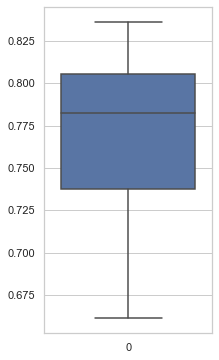

In [30]:
plt.figure(figsize=(3,6))
sns.boxplot(data=scores)
plt.show()

# Prediction

In [32]:
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
# prob_train_pred = model.predict_proba(X_train)

y_test_pred = model.predict(X_test)
# prob_test_pred = model.predict_proba(X_test)

# Model Evaluation

### Accuracy

In [33]:
accuracy_score(y_train, y_train_pred)

0.7785016286644951

In [34]:
accuracy_score(y_test, y_test_pred)

0.7987012987012987

### Confusion matrix

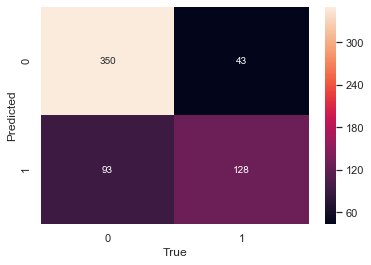

In [35]:
cm_df = pd.DataFrame(confusion_matrix(y_train, y_train_pred))
cm_df.index.name = 'Predicted'
cm_df.columns.name = 'True'
sns.heatmap(cm_df, annot=True, fmt="d")
plt.show()

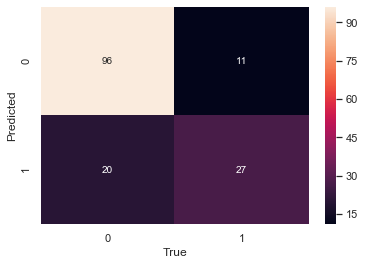

In [36]:
cm_df = pd.DataFrame(confusion_matrix(y_test, y_test_pred))
cm_df.index.name = 'Predicted'
cm_df.columns.name = 'True'
sns.heatmap(cm_df, annot=True, fmt="d")
plt.show()

### Classification Report

In [37]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.79      0.89      0.84       393
           1       0.75      0.58      0.65       221

    accuracy                           0.78       614
   macro avg       0.77      0.73      0.75       614
weighted avg       0.78      0.78      0.77       614



In [38]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.83      0.90      0.86       107
           1       0.71      0.57      0.64        47

    accuracy                           0.80       154
   macro avg       0.77      0.74      0.75       154
weighted avg       0.79      0.80      0.79       154



### ROC AUC Score

In [39]:
roc_auc_score(y_train, y_train_pred)

0.7348853810461355

In [40]:
roc_auc_score(y_test, y_test_pred)

0.7358321733943131

### ROC Curve

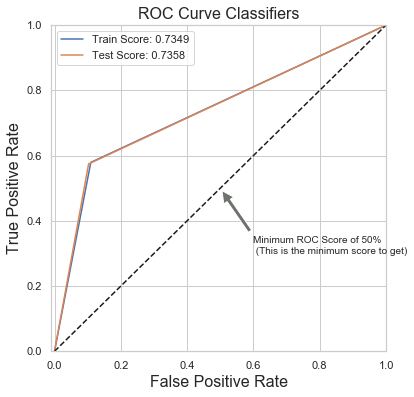

In [41]:
from sklearn.metrics import roc_curve

fpr_train, tpr_train, threshold = roc_curve(y_train, y_train_pred)
fpr_test, tpr_test, threshold = roc_curve(y_test, y_test_pred)

plt.figure(figsize=(6,6))
plt.title('ROC Curve Classifiers', fontsize=16)
plt.plot(fpr_train, tpr_train, label= 'Train Score: {:.4f}'.format(roc_auc_score(y_train, y_train_pred)))
plt.plot(fpr_test, tpr_test, label= 'Test Score: {:.4f}'.format(roc_auc_score(y_test, y_test_pred)))

plt.plot([0, 1], [0, 1], 'k--')
plt.axis([-0.01, 1, 0, 1])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05))
plt.legend()
        
plt.show()


### Precision-Recall curve

Text(0.5, 1.0, 'Precision-Recall curve: \n Average Precision-Recall Score =0.76')

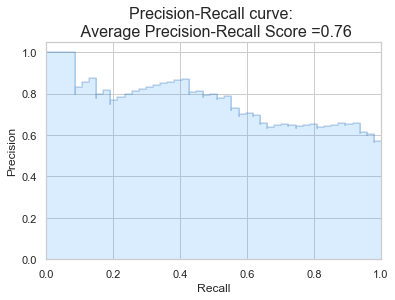

In [43]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

y_score = model.decision_function(X_test)
precision, recall, threshold = precision_recall_curve(y_test,y_score)
average_precision = average_precision_score(y_test, y_score)


plt.step(recall, precision, color='#004a93', alpha=0.2,where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='#48a6ff')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(average_precision), fontsize=16)

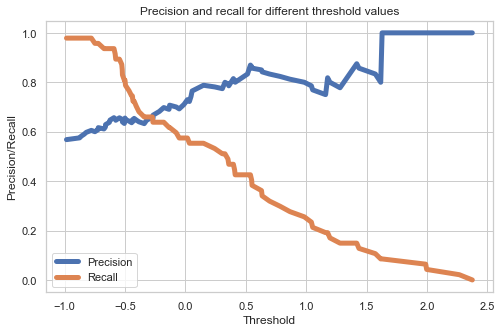

In [44]:
plt.figure(figsize=(8,5))
plt.plot(threshold, precision[1:], label="Precision",linewidth=5)
plt.plot(threshold, recall[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Precision-Recall curve: \n Average Precision-Recall Score =0.73')

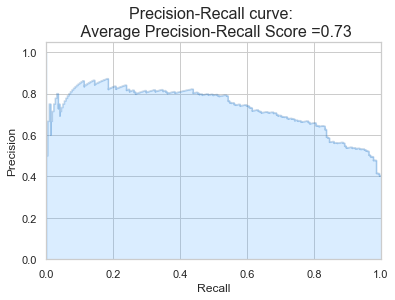

In [45]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

y_score = model.decision_function(X_train)
precision, recall, threshold = precision_recall_curve(y_train,y_score)
average_precision = average_precision_score(y_train, y_score)


plt.step(recall, precision, color='#004a93', alpha=0.2,where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='#48a6ff')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(average_precision), fontsize=16)

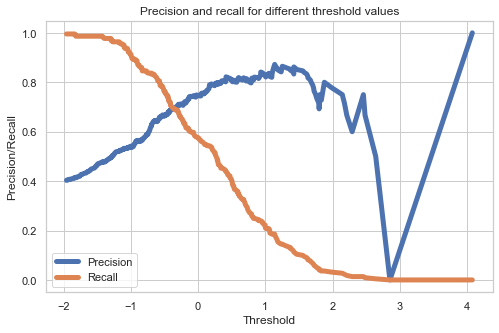

In [46]:
plt.figure(figsize=(8,5))
plt.plot(threshold, precision[1:], label="Precision",linewidth=5)
plt.plot(threshold, recall[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

### Summary

In [49]:
def ModelEvaluation(model,X_train,y_train,X_test,y_test,name):
    print('Model Evaluation of ' + name)

    print('-----------------------------------------------------------')
    print('Train set')
    print('Accuracy: ', accuracy_score(y_train, y_train_pred))
    print('ROC AUC Score: ', roc_auc_score(y_train, y_train_pred))
    cm_df = pd.DataFrame(confusion_matrix(y_train,y_train_pred), index=model.classes_,columns=model.classes_)
    cm_df.index.name = 'Predicted'
    cm_df.columns.name = 'True'
    print('Confusion matrix')
    print(cm_df)
    print(classification_report(y_train, y_train_pred))
    
    print('-----------------------------------------------------------')
    print('Test set')
    print('Accuracy: ', accuracy_score(y_test, y_test_pred))
    print('ROC AUC Score: ', roc_auc_score(y_test, y_test_pred))
    cm_df = pd.DataFrame(confusion_matrix(y_test,y_test_pred), index=model.classes_,columns=model.classes_)
    cm_df.index.name = 'Predicted'
    cm_df.columns.name = 'True'
    print('Confusion matrix')
    print(cm_df)
    print(classification_report(y_test, y_test_pred))

In [50]:
ModelEvaluation(model,X_train,y_train,X_test,y_test,'LinearSVM')

Model Evaluation of LinearSVM
-----------------------------------------------------------
Train set
Accuracy:  0.7785016286644951
ROC AUC Score:  0.7348853810461355
Confusion matrix
True         0    1
Predicted          
0          350   43
1           93  128
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       393
           1       0.75      0.58      0.65       221

    accuracy                           0.78       614
   macro avg       0.77      0.73      0.75       614
weighted avg       0.78      0.78      0.77       614

-----------------------------------------------------------
Test set
Accuracy:  0.7987012987012987
ROC AUC Score:  0.7358321733943131
Confusion matrix
True        0   1
Predicted        
0          96  11
1          20  27
              precision    recall  f1-score   support

           0       0.83      0.90      0.86       107
           1       0.71      0.57      0.64        47

    accuracy            